In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.estela import Predictor
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, TWL, AnnualMaxima, Aggregate_WavesFamilies, Intradaily_Hydrograph
from teslakit.custom_dateutils import xds_limit_dates as limdates
from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim
from teslakit.plotting.output import Plot_Output



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# Load data for climate emulator fitting: waves partitions and families, KMA, DWT

xds_WVS_pts = db.Load_WAVES_partitions()       # waves partitions data (hourly)
xds_WVS_fam = db.Load_WAVES_fams_noTCs()       # wave families sea, swell_1, swell_2 (TCs removed)

xds_KMA = db.Load_ESTELA_KMA()                 # ESTELA predictor KMA

d_WT_TCs_wvs = db.Load_WAVES_fams_TCs_categ()  # TCs-window waves-families data by category

# prepare KMA data 
xds_KMA = xr.Dataset(
    {
        'bmus'       : ('time', xds_KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), xds_KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : xds_KMA['time'].values[:]}
)


# --------------------------------------
# Load data for climate emulator simulation: ESTELA DWT and TCs (MU, TAU) 

xds_DWT = db.Load_ESTELA_DWT_sim()

xds_TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
xds_TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

xds_probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = xds_probs_TCs['category_change_cumsum'].values[:]

xdsets_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each WWT
MU_WT = np.array([x.MU.values[:] for x in xdsets_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in xdsets_mutau_wt])


In [4]:
# --------------------------------------
# MATLAB TEST DATA OVERRIDE (year 1700-2700, DWTs bmus 1-42 + DWTs-TCs for 37-42)

from teslakit.io.matlab import ReadMatfile
from teslakit.custom_dateutils import datevec2datetime as d2d
from teslakit.custom_dateutils import DateConverter_Mat2Py as dmp

# Test data storage
p_test = op.join(p_data, 'tests', 'ClimateEmulator', 'ml_jupyter')

# load test KMA (bmus, time, number of clusters, cenEOFs)
p_bmus = op.join(p_test, 'bmus_testearpython.mat')
dmatf = ReadMatfile(p_bmus)
xds_KMA = xr.Dataset(
    {
        'bmus'       : ('time', dmatf['KMA']['bmus']),
        'cenEOFs'    : (('n_clusters', 'n_features',), dmatf['KMA']['cenEOFs']),
    },
    coords = {'time' : np.array(d2d(dmatf['KMA']['Dates']))}
)

# DWTs (Daily Weather Types simulated using ALR) (year 1700-2700)
p_DWTs = op.join(p_test, 'DWT_1000years_mjo_awt_v2.mat')
dm_DWTs = ReadMatfile(p_DWTs)
xds_DWT = xr.Dataset(
    {
        'evbmus_sims' : (('time', 'n_sim'), dm_DWTs['bmusim'].T),
    },
    coords = {'time' : dmp(dm_DWTs['datesim'])}
)

# get WTs37, 42 from matlab file
p_WTTCs = op.join(p_test, 'KWA_waves_2PART_TCs_nan.mat')
dm_WTTCs = ReadMatfile(p_WTTCs)

# Load TCs-window waves-families data by category
d_WTTCs = {}
for i in range(6):

    k = 'wt{0}'.format(i+1+36)
    sd = dm_WTTCs[k]

    d_WTTCs['{0}'.format(i+1+36)] = xr.Dataset(
        {
            'sea_Hs'      : (('time',), sd['seaHs']),
            'sea_Dir'     : (('time',), sd['seaDir']),
            'sea_Tp'      : (('time',), sd['seaTp']),
            'swell_1_Hs'  : (('time',), sd['swl1Hs']),
            'swell_1_Dir' : (('time',), sd['swl1Dir']),
            'swell_1_Tp'  : (('time',), sd['swl1Tp']),
            'swell_2_Hs'  : (('time',), sd['swl2Hs']),
            'swell_2_Dir' : (('time',), sd['swl2Dir']),
            'swell_2_Tp'  : (('time',), sd['swl2Tp']),
        }
    )



## Climate Emulator - Fitting

In [5]:
# --------------------------------------
# Climate Emulator extremes model fitting

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

# Waves and KMA bmus data share time dimension
xds_WVS_fam = xds_WVS_fam.sel(time=xds_KMA.time)
xds_WVS_pts = xds_WVS_pts.sel(time=xds_KMA.time)

# Fit extremes model
config = {
    'name_fams':       ['sea', 'swell_1', 'swell_2'],
    'force_empirical': ['sea_Tp'],
}

#CE.FitExtremes(xds_KMA, xds_WVS_pts, xds_WVS_fam, config)

# TODO: dev plots and complete script
CE.Load()


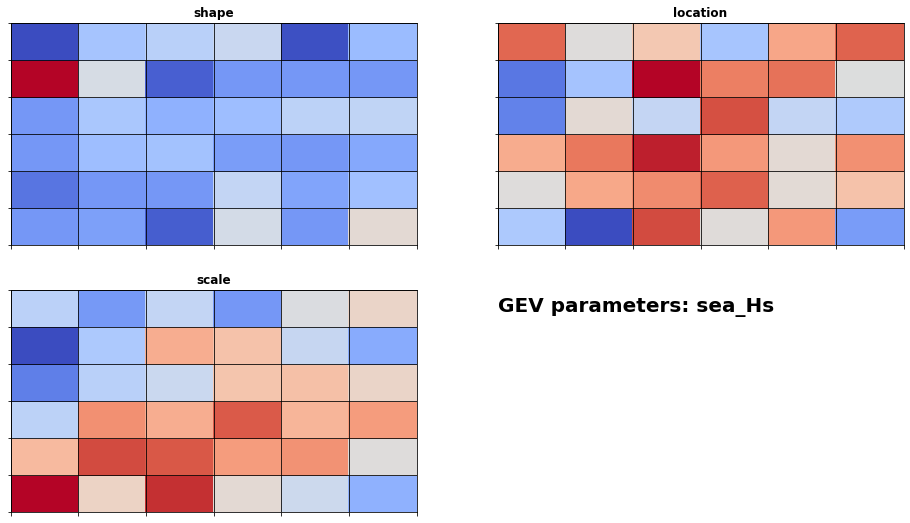

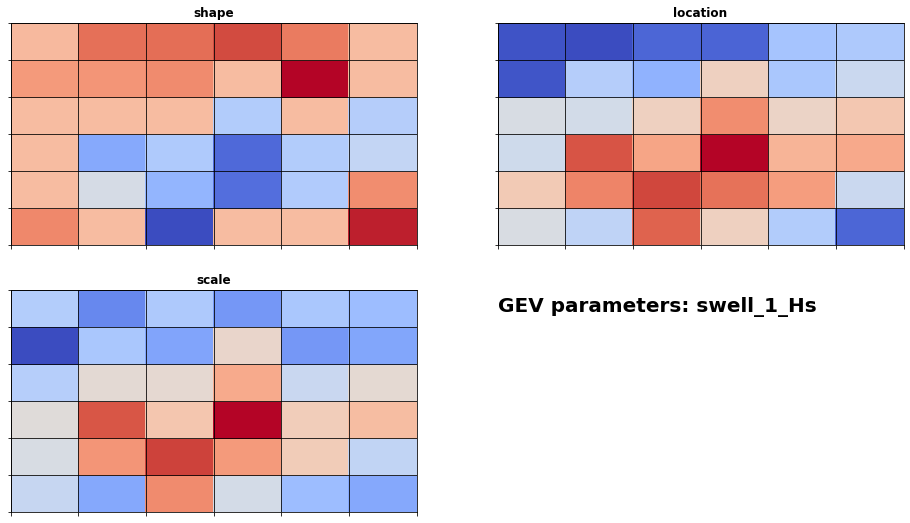

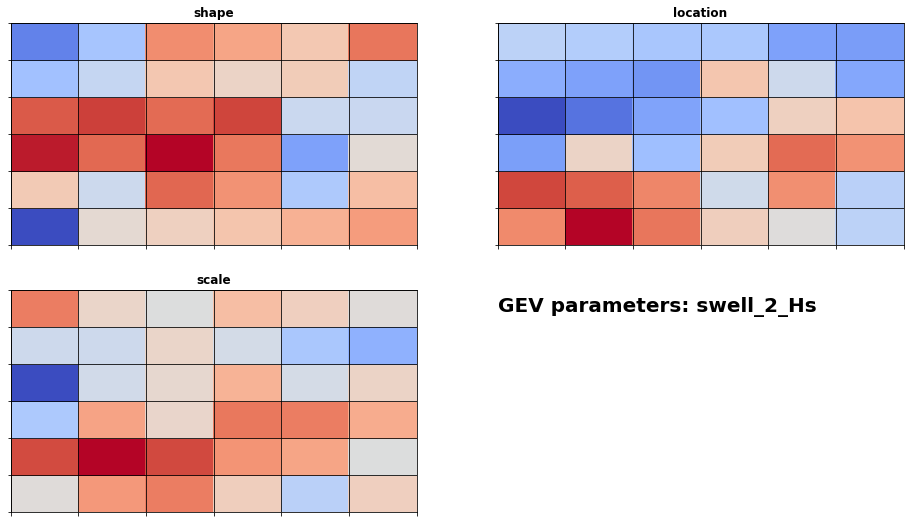

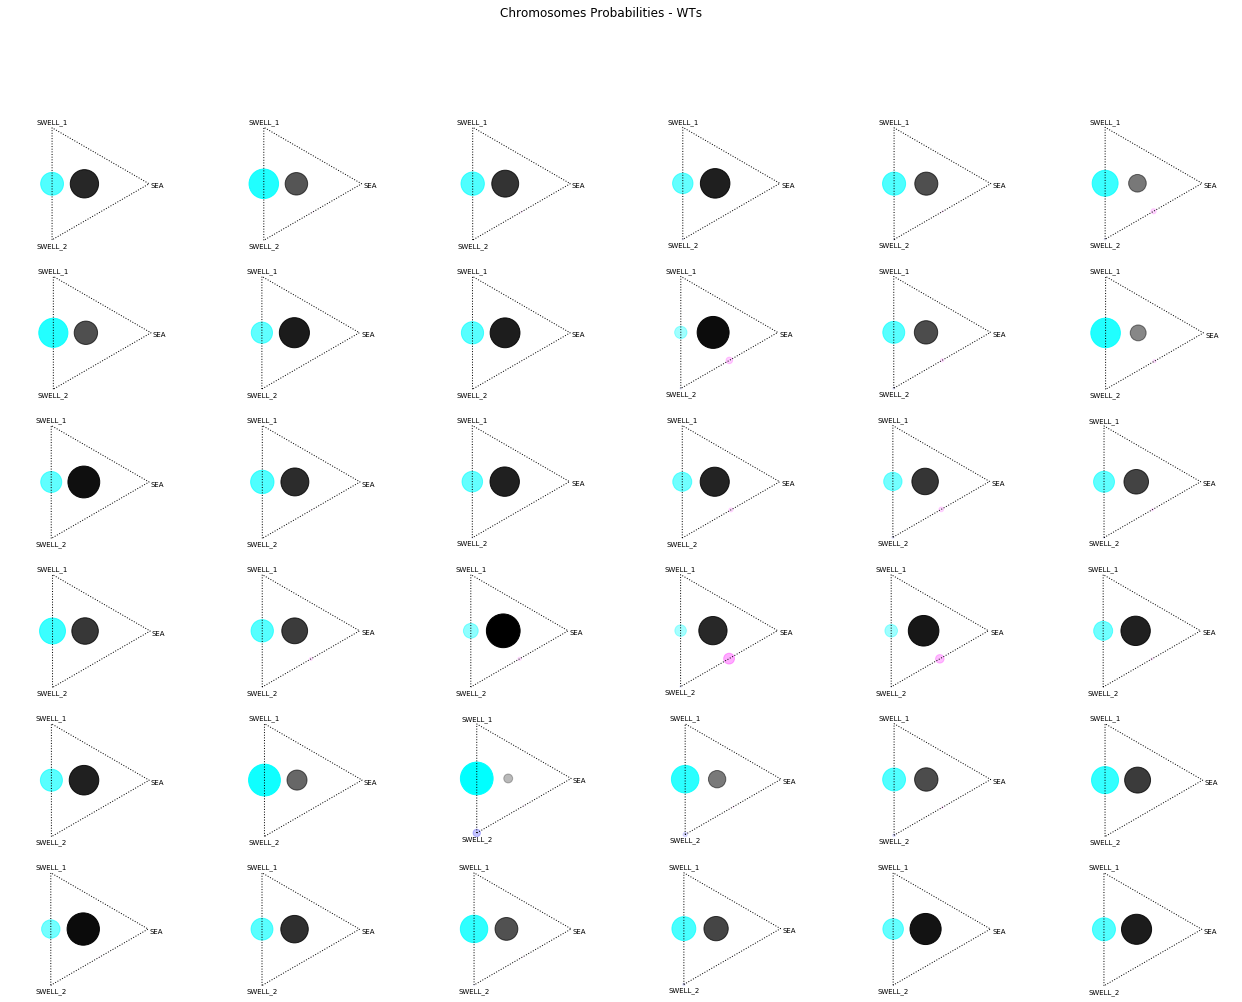

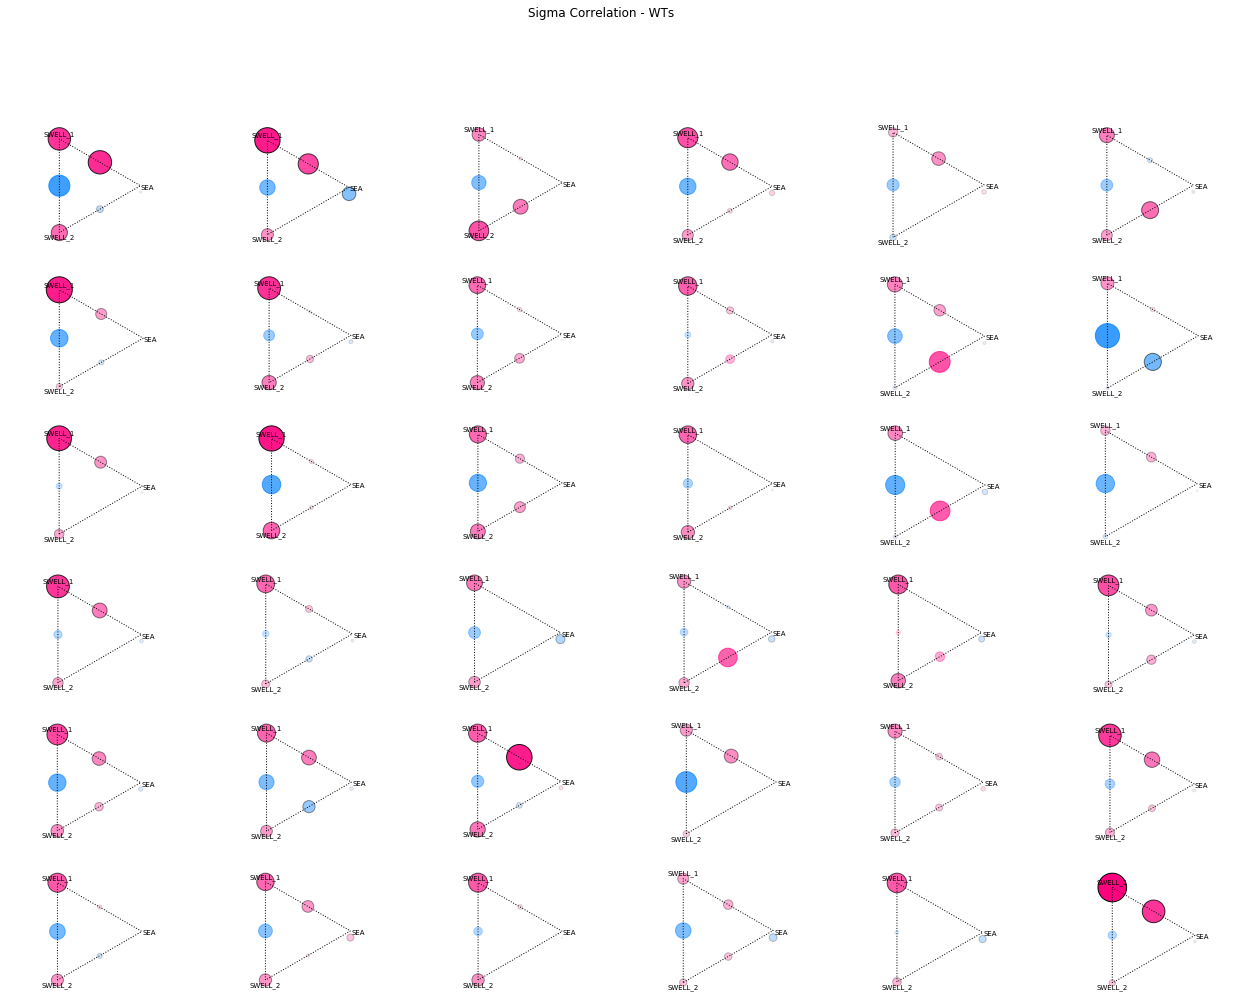

In [6]:
# Fit report figures
CE.Report_Fit()



## Climate Emulator - Simulation

In [7]:
# TODO: testing simulation period
xds_DWT = xds_DWT.isel(time=slice(0,10*365), n_sim=slice(0,1))

print(xds_DWT)


<xarray.Dataset>
Dimensions:      (n_sim: 1, time: 3650)
Coordinates:
  * time         (time) object 1700-01-01 1700-01-02 ... 1709-12-28 1709-12-29
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) uint8 22 22 17 17 17 17 17 ... 17 11 17 17 17 17


In [8]:
# --------------------------------------
#  Climate Emulator simulation (NO TCs)

# Simulate waves
ls_wvs_sim = CE.Simulate_Waves(xds_DWT, d_WTTCs)

# Simulate TCs and update simulated waves
ls_tcs_sim, ls_wvs_upd = CE.Simulate_TCs(xds_DWT, d_WTTCs, xds_TCs_params, xds_TCs_RBFs, pchange_TCs, MU_WT, TAU_WT)

#ls_wvs_upd, ls_tcs_sim = CE.LoadSim(TCs=True)


C.E: Sim. TCs  : 100%|██████████| 1824/1824 [00:00<00:00, 8268.67it/s]


In [9]:
# Select Simulation to solve
n_sim = 0
wvs_sim, tcs_sim = ls_wvs_upd[n_sim], ls_tcs_sim[n_sim]



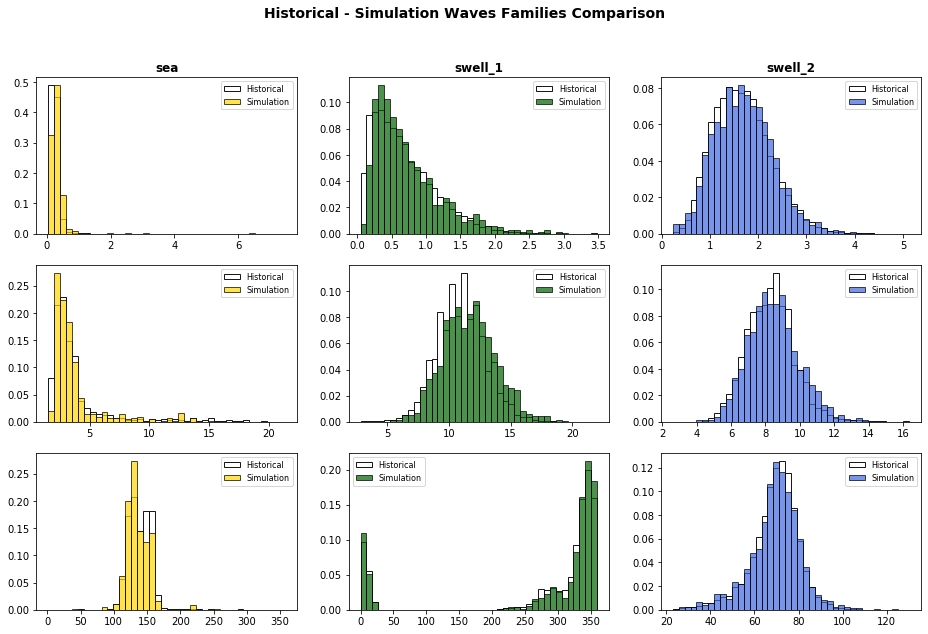

In [10]:
# Plot simulated waves parameters distribution 

Plot_Waves_Histogram_FitSim(xds_WVS_fam, wvs_sim)
    


## Climate Emulator - Complete Output

In [11]:
# --------------------------------------
# Get all simulated data (hourly): AWTs, DWTs, MJO, MMSL, AT

xds_AWTs_h = db.Load_SST_AWT_sim().resample(time='1H').pad().isel(n_sim=n_sim)
xds_DWTs_h = xds_DWT.resample(time='1H').pad().isel(n_sim=n_sim)
xds_MJO_h = db.Load_MJO_sim().resample(time='1H').pad().isel(n_sim=n_sim)
xds_MMSL_h = db.Load_TIDE_sim_mmsl_h().isel(n_sim=n_sim)
xds_AT_h = db.Load_TIDE_sim_astro() 


In [12]:
# --------------------------------------
#  Complete simulation 

def CompleteOutput(xds_h, xds_AWTs, xds_MJO, xds_DWTs, xds_AT, xdx_MMSL):
    'Adds AWTs, MJO, DWTs, AT, MMSL to hourly sim. output'

    # common output dates
    d1, d2 = limdates([xds_h, xds_AWTs, xds_MJO, xds_DWTs, xds_AT, xdx_MMSL])
    
    xds_h = xds_h.sel(time=slice(d1,d2))
    xds_AWTs = xds_AWTs.sel(time=slice(d1,d2))
    xds_MJO = xds_MJO.sel(time=slice(d1,d2))
    xds_DWTs = xds_DWTs.sel(time=slice(d1,d2))
    xds_AT = xds_AT.sel(time=slice(d1,d2))
    xdx_MMSL = xdx_MMSL.sel(time=slice(d1,d2))
    
    # add all data
    xds_h['AWT'] = (('time',), xds_AWTs.evbmus_sims.values[:])
    xds_h['MJO'] = (('time',), xds_MJO.evbmus_sims.values[:])        
    xds_h['DWT'] = (('time',), xds_DWTs.evbmus_sims.values[:])
    xds_h['MMSL'] = (('time',), xdx_MMSL.mmsl.values[:]) 
    xds_h['AT'] = (('time',), xds_AT.tide.values[:])
    
    return xds_h
    
def Simulation_PostProc(xds_wvs_sim, xds_tcs_sim, xds_AWTs_h, xds_MJO_h, xds_DWTs_h, xds_AT_h, xds_MMSL_h):
    'final stepss and calculation for simulated data'
    
    # Aggregate waves families data 
    xds_wvs_agr = Aggregate_WavesFamilies(xds_wvs_sim)

    
    # --------------------------------------
    # Hourly Hydrographs
    
    # Calculate Intradaily hourly hydrographs for simulated storms
    xds_hy = Intradaily_Hydrograph(xds_wvs_agr, xds_tcs_sim)
    
    # Complete hourly output with: AWTs, MJO, DWTs, MMSL, AT
    xds_hy = CompleteOutput(xds_hy, xds_AWTs_h, xds_MJO_h, xds_DWTs_h, xds_AT_h, xds_MMSL_h)
    
    # Calculate hourly Atmospheric Water Level and Total Water Level
    hs = xds_hy.Hs.values[:]
    tp = xds_hy.Tp.values[:]
    ss = xds_hy.SS.values[:]
    at = xds_hy.AT.values[:]
    ml = xds_hy.MMSL.values[:]
    
    awl = AWL(hs, tp)
    twl = TWL(awl, ss, at, ml)
    
    xds_hy['AWL'] = (('time',), awl)
    xds_hy['TWL'] = (('time',), twl)

    
    # --------------------------------------
    # Annual Maxima
    
    # Calculate AWL for aggregated waves data (storms)
    hs = xds_wvs_agr.Hs.values[:]
    tp = xds_wvs_agr.Tp.values[:]

    awl = AWL(hs, tp)
    xds_wvs_agr['AWL'] = (('time',), awl)

    # Calculate annual maxima
    xds_AMax = AnnualMaxima(xds_wvs_agr, 'AWL')
    
    # Complete Annual Maxima output
    xds_hy_AMax = xds_hy.sel(time=xds_AMax.time)
    for k in xds_hy_AMax.keys():
        if k not in xds_AMax.keys():
            xds_AMax[k] = xds_hy_AMax[k].copy()
    
    return xds_hy, xds_AMax
    
    
# Complete simulated hourly data
xds_hy, xds_AMax = Simulation_PostProc(
    wvs_sim, tcs_sim,
    xds_AWTs_h, xds_MJO_h, xds_DWTs_h, xds_AT_h, xds_MMSL_h
)
    
print(xds_hy)
print()
print(xds_AMax)
print()
    

<xarray.Dataset>
Dimensions:  (time: 87505)
Coordinates:
  * time     (time) datetime64[ns] 1700-01-01 1700-01-01T01:00:00 ... 1709-12-26
Data variables:
    Hs       (time) float64 1.894 1.879 1.863 1.848 ... 0.4505 0.3624 0.2744
    Tp       (time) float64 8.12 8.12 8.12 8.12 8.12 ... 9.579 9.579 9.579 9.096
    Dir      (time) float64 75.8 75.8 75.8 75.8 75.8 ... 83.14 83.14 83.14 91.99
    SS       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    AWT      (time) float32 5.0 5.0 5.0 5.0 5.0 5.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    MJO      (time) float32 23.0 23.0 23.0 23.0 23.0 ... 25.0 25.0 25.0 25.0
    DWT      (time) uint8 22 22 22 22 22 22 22 22 22 ... 11 11 11 11 11 11 11 17
    MMSL     (time) float32 -0.039528113 -0.039528113 ... -0.072690286
    AT       (time) float32 -0.6343058 -0.49589092 ... -0.5961449 -0.4700299
    AWL      (time) float64 0.6002 0.5978 0.5953 0.5929 ... 0.3453 0.3097 0.2559
    TWL      (time) float64 -0.07361 0.06236 0.3238 ... -0.2

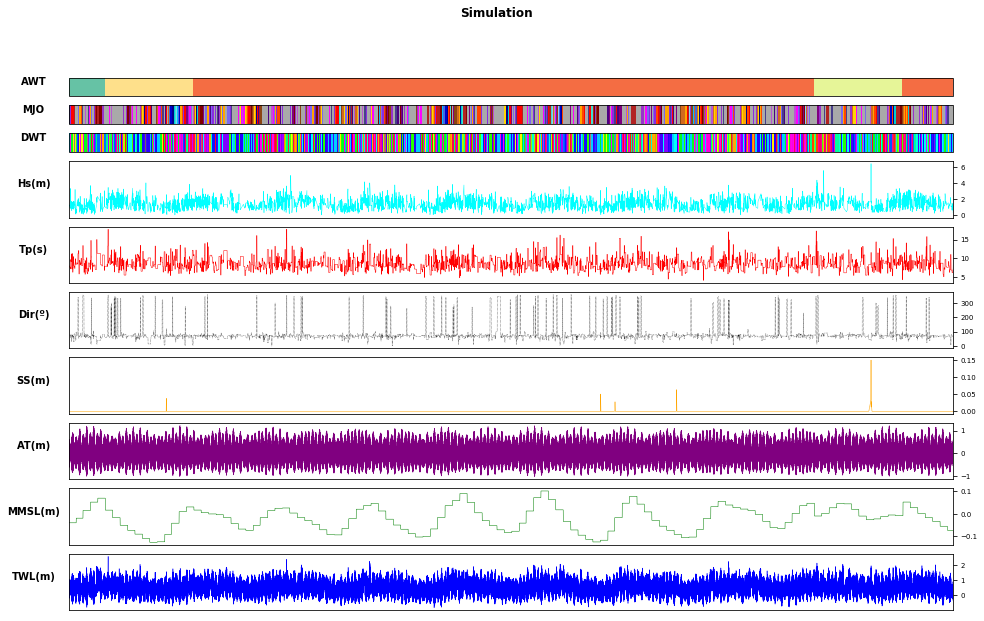

In [13]:
# Plot simulated output

Plot_Output(xds_hy)


In [14]:
    
# TODO: el ploteo TL,HS,Dir,Tp,WL se hace con estos datos anuales
# TODO: a partir de los datos maximos anuales se pintan periodos de retorno
